# Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Linear regression

## The normal equation

In [2]:
np.random.seed(42)  # for the sake of reproducibility

m = 100  # number of instances
X = 2 * np.random.rand(m, 1)  # column vector
y = 4 + 3 * X + np.random.randn(m, 1)

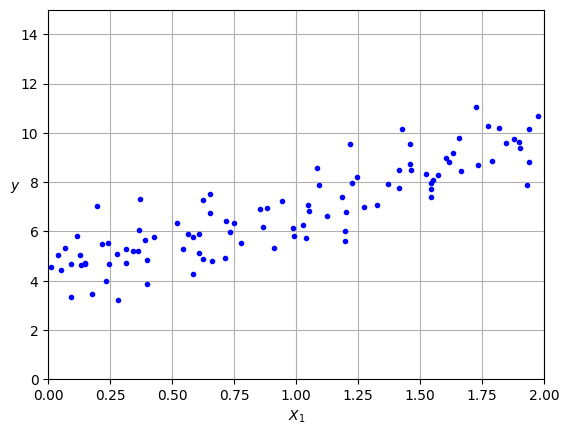

In [3]:
plt.plot(X, y, "b.")

plt.xlabel("$X_1$")
plt.ylabel("$y$", rotation=0)
plt.grid()
plt.axis([0, 2, 0, 15])

plt.show()

In [4]:
from sklearn.preprocessing import add_dummy_feature

X_b = add_dummy_feature(X)  # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

In [5]:
theta_best

array([[4.21509616],
       [2.77011339]])

In [6]:
X_new = np.array([[0], [2]])
X_new_b = add_dummy_feature(X_new)
y_predict = X_new_b @ theta_best
y_predict

array([[4.21509616],
       [9.75532293]])

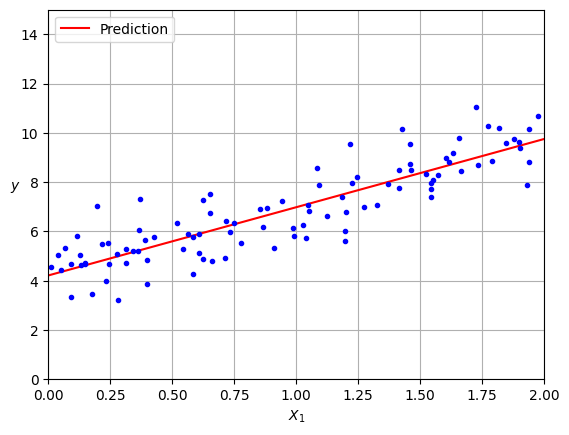

In [7]:
plt.plot(X_new, y_predict, "r-", label="Prediction")
plt.plot(X, y, "b.")

plt.xlabel("$X_1$")
plt.ylabel("$y$", rotation=0)
plt.grid()
plt.axis([0, 2, 0, 15])
plt.legend(loc="upper left")

plt.show()

In [8]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [9]:
lin_reg.coef_

array([[2.77011339]])

In [10]:
lin_reg.intercept_

array([4.21509616])

In [11]:
lin_reg.predict(X_new)

array([[4.21509616],
       [9.75532293]])

LinearRegression class is based on scipy.linalg.lstsq() function (the name stands for "least square"). We can call it directly using np.linalg.lstsq().

In [12]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best

array([[4.21509616],
       [2.77011339]])

This function compute $\hat{\theta} = X^+y$ where $X^+$ is the *pseudoinverse* of X (specifically, the Moore-Penrose inverse). We can use np.linalg.pinv() to directly compute the pseudoinverse.

In [13]:
np.linalg.pinv(X_b) @ y

array([[4.21509616],
       [2.77011339]])

# Gradient descent

In [14]:
eta = 0.1
n_epochs = 1000
m = len(X_b)

np.random.seed(42)
theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    gradient = 2 / m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradient

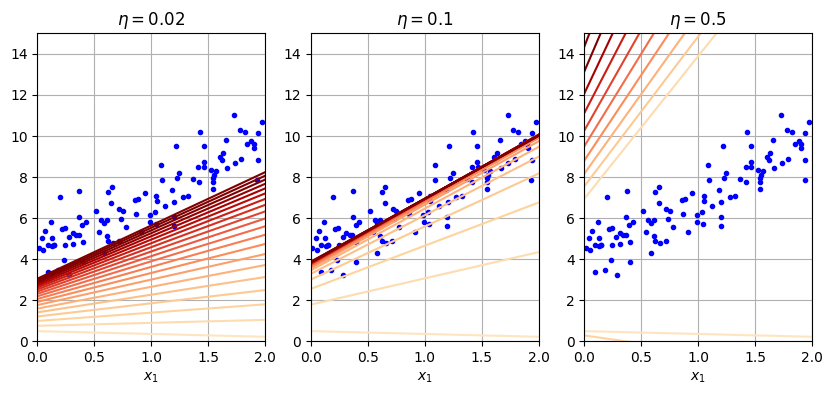

In [15]:
import matplotlib


def plot_gradient_descent(theta, eta):
    m = len(X_b)
    n_epochs = 1000
    n_shown = 20
    plt.plot(X, y, "b.")
    theta_path = []
    for epoch in range(n_epochs):
        if epoch < n_shown:
            y_predict = X_new_b @ theta
            color = matplotlib.colors.rgb2hex(plt.cm.OrRd(epoch / n_shown + 0.15))
            plt.plot(X_new, y_predict, linestyle="solid", color=color)
        gradient = 2 / m * X_b.T @ (X_b @ theta - y)
        theta = theta - eta * gradient
        theta_path.append(theta)
    plt.xlabel("$x_1$")
    plt.axis([0, 2, 0, 15])
    plt.grid()
    plt.title(rf"$\eta = {eta}$")
    return theta_path


np.random.seed(42)
theta = np.random.randn(2, 1)

plt.figure(figsize=(10, 4))
plt.subplot(131)
plot_gradient_descent(theta, eta=0.02)
plt.xlabel("$x_1$")
plt.subplot(132)
theta_path_bgd = plot_gradient_descent(theta, eta=0.1)  # save for later comparison
plt.xlabel("$x_1$")
plt.subplot(133)
plot_gradient_descent(theta, eta=0.5)
plt.xlabel("$x_1$")
plt.show()

# Stochastic Gradient Descent

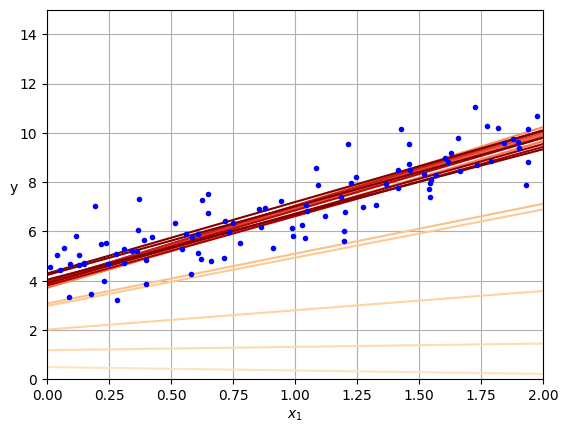

In [16]:
n_epochs = 50
t0, t1 = 5, 50  # learning schedule hyperparameter


def learning_schedule(t):
    return t0 / (t1 + t)


np.random.seed(42)
theta = np.random.randn(2, 1)

n_shown = 20
theta_path_sgd = []

for epoch in range(n_epochs):
    for iteration in range(m):
        if epoch == 0 and iteration < n_shown:
            y_predcit = X_new_b @ theta
            color = matplotlib.colors.rgb2hex(plt.cm.OrRd(iteration / n_shown + 0.15))
            plt.plot(X_new, y_predcit, linestyle="solid", color=color)

        random_index = np.random.randint(m)
        xi = X_b[random_index : random_index + 1]
        yi = y[random_index : random_index + 1]

        gradient = 2 * xi.T @ (xi @ theta - yi)  # we train on 1 instance so m = 1
        eta = learning_schedule(epoch * m + iteration)
        theta = theta - eta * gradient
        theta_path_sgd.append(theta)


plt.plot(X, y, "b.")
plt.grid()
plt.axis([0, 2, 0, 15])
plt.xlabel("$x_1$")
plt.ylabel("y", rotation=0)
plt.show()

Here we train on a random instance, but an instance can be choose multiple times. But because we choose randomly, the result would be the same as we make sure every chosen instance. If you want to approach that way, you can shuffle the index, go through the train set, then shuffle and train again and again.

In [17]:
theta

array([[4.21076011],
       [2.74856079]])

You can use SGDRegressor class in Scikit-learn instead of implement SGD from scratch. It default to use MSE for scoring. <br>
The following code:
- run for maximum 1000 epochs (max_iter) or until the loss drops by less than $10^{-5}$ (tol) during the first 100 epochs (n_iter_no_change). 
- It start with the learning rate of 0.01 (eta0), using the default learning schedule (which is different from the one we used). 
- Lastly, it does not use any regularization (penalty=None, more on that later).

In [18]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(
    max_iter=1000,
    tol=1e-5,
    penalty=None,
    eta0=0.01,
    n_iter_no_change=100,
    random_state=42,
)
sgd_reg.fit(X, y.ravel())  # y.ravel() because fit() expect 1D array

SGDRegressor(n_iter_no_change=100, penalty=None, random_state=42, tol=1e-05)

In [19]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.21278812]), array([2.77270267]))

# Mini-batch Gradient Descent

In [20]:
from math import ceil

n_epochs = 50
minibatch_sizes = 20
n_batches_per_epoch = ceil(m / minibatch_sizes)

np.random.seed(42)
theta = np.random.randn(2, 1)

t0, t1 = 200, 1000


def learning_schedule(t):
    return t0 / (t + t1)


theta_path_mgd = []
for epoch in range(n_epochs):
    shuffled_indices = np.random.permutation(m)
    X_b_shuffled = X_b[shuffled_indices]
    y_shuffled = y[shuffled_indices]
    for iteration in range(0, n_batches_per_epoch):
        index = minibatch_sizes * iteration
        xi = X_b_shuffled[index : index + minibatch_sizes]
        yi = y_shuffled[index : index + minibatch_sizes]

        gradient = 2 / minibatch_sizes * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(epoch * n_batches_per_epoch + iteration)
        theta = theta - eta * gradient
        theta_path_mgd.append(theta)

In [21]:
theta_path_bgd = np.array(theta_path_bgd)
theta_path_sgd = np.array(theta_path_sgd)
theta_path_mgd = np.array(theta_path_mgd)

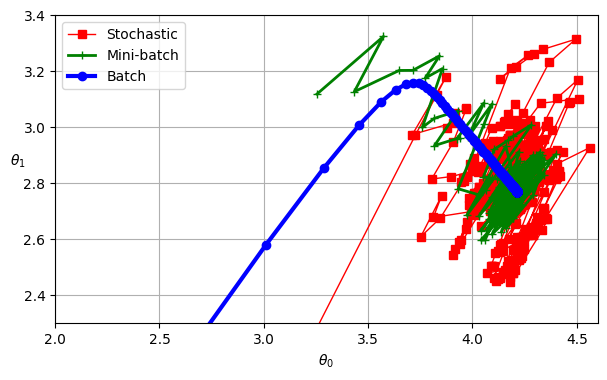

In [22]:
plt.figure(figsize=(7, 4))
plt.plot(
    theta_path_sgd[:, 0], theta_path_sgd[:, 1], "r-s", linewidth=1.0, label="Stochastic"
)
plt.plot(
    theta_path_mgd[:, 0], theta_path_mgd[:, 1], "g-+", linewidth=2.0, label="Mini-batch"
)
plt.plot(
    theta_path_bgd[:, 0], theta_path_bgd[:, 1], "b-o", linewidth=3.0, label="Batch"
)

plt.legend(loc="upper left")
plt.axis([2.0, 4.6, 2.3, 3.4])
plt.xlabel(r"$\theta_0$")
plt.ylabel(r"$\theta_1$", rotation=0)
plt.grid()
plt.show()

# Polynomial Regression

In [23]:
np.random.seed(42)

m = 100  # number of instances
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)

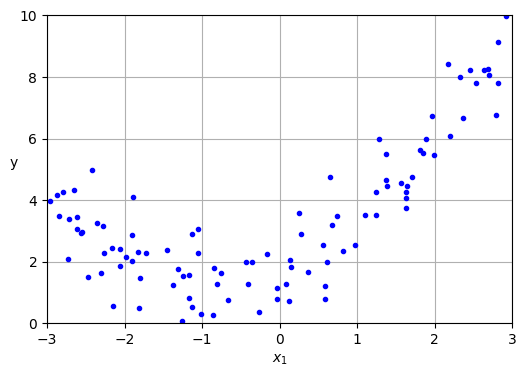

In [24]:
plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.axis([-3, 3, 0, 10])
plt.xlabel("$x_1$")
plt.ylabel("y", rotation=0)
plt.grid()
plt.show()

In [25]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [26]:
X[0]

array([-0.75275929])

In [27]:
X_poly[0]

array([-0.75275929,  0.56664654])

X_poly now contains the original feature plus the square of this feature.

In [28]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)

LinearRegression()

In [29]:
lin_reg.intercept_, lin_reg.coef_

(array([1.78134581]), array([[0.93366893, 0.56456263]]))

So the model estimates $\hat{y} = 0.56.x^2+0.93.x+1.78$ when in fact the underlying function is $y = 0.5.x^2+x+2+$ Gaussian noise.

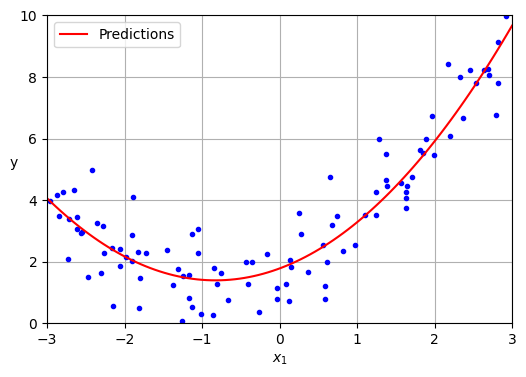

In [30]:
X_new = np.linspace(-3, 3, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)

plt.figure(figsize=(6, 4))
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", label="Predictions")

plt.legend(loc="upper left")
plt.grid()
plt.xlabel("$x_1$")
plt.ylabel("y", rotation=0)
plt.axis([-3, 3, 0, 10])
plt.show()

# Learning curves

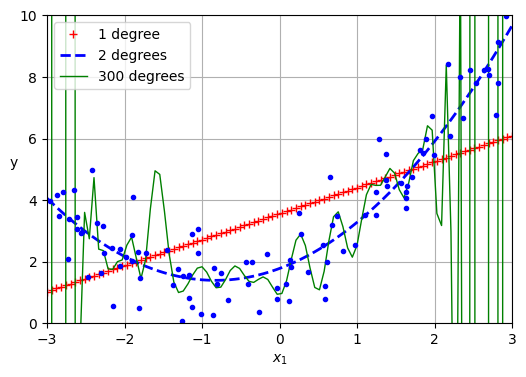

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

plt.figure(figsize=(6, 4))

for style, width, degree in [("r+", 2, 1), ("b--", 2, 2), ("g-", 1, 300)]:
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = make_pipeline(polybig_features, std_scaler, lin_reg)
    polynomial_regression.fit(X, y)
    y_newbig = polynomial_regression.predict(X_new)
    label = f"{degree} degree{'s' if degree > 1 else ''}"
    plt.plot(X_new, y_newbig, style, label=label, linewidth=width)

plt.plot(X, y, "b.")
plt.legend(loc="upper left")
plt.axis([-3, 3, 0, 10])
plt.xlabel("$x_1$")
plt.ylabel("y", rotation=0)
plt.grid()
plt.show()

Scikit-learn has learning_curve() function to help: It automatically trains and evaluates the model using cross-validation. 

It trains the model on growing subsets of the training set by default, but if the model support incrementally learning, then you can set exploit_incremental_learning=True when calling learning_curve() and it will train the model incrementally instead.

The function returns the training set size at which it evaluated the model, the training and validation score for each size and for each cross-validation fold.  

In [32]:
from sklearn.model_selection import learning_curve

train_size, train_scores, valid_scores = learning_curve(
    LinearRegression(),
    X,
    y,
    train_sizes=np.linspace(0.01, 1.0, 40),
    cv=5,
    scoring="neg_root_mean_squared_error",
)

In [33]:
train_error = -train_scores.mean(axis=1)
valid_error = -valid_scores.mean(axis=1)

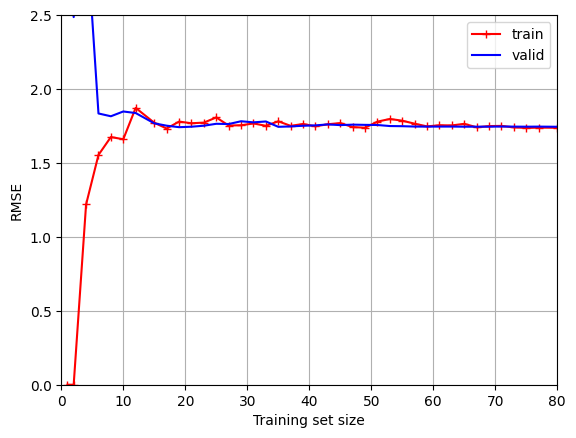

In [34]:
plt.plot(train_size, train_error, "r-+", label="train")
plt.plot(train_size, valid_error, "b-", label="valid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.legend(loc="upper right")
plt.axis([0, 80, 0.0, 2.5])
plt.grid()
plt.show()

Now we train a 10th-degree polynomial model.

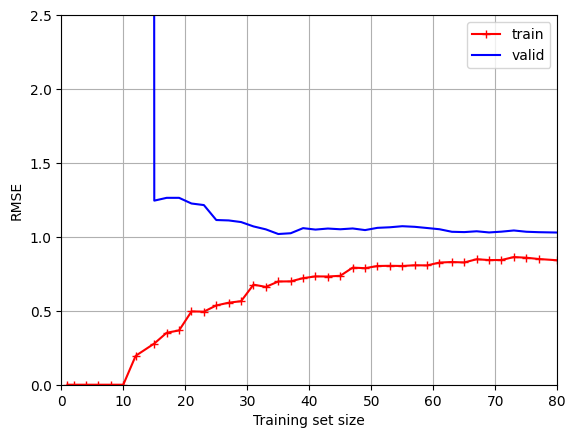

In [35]:
polynomial_regression = make_pipeline(
    PolynomialFeatures(degree=10, include_bias=False), LinearRegression()
)

train_size, train_scores, valid_scores = learning_curve(
    polynomial_regression,
    X,
    y,
    train_sizes=np.linspace(0.01, 1.0, 40),
    cv=5,
    scoring="neg_root_mean_squared_error",
)

train_error = -train_scores.mean(axis=1)
valid_error = -valid_scores.mean(axis=1)

plt.plot(train_size, train_error, "r-+", label="train")
plt.plot(train_size, valid_error, "b-", label="valid")

plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.legend(loc="upper right")
plt.axis([0, 80, 0.0, 2.5])
plt.grid()
plt.show()

# Regularized Linear Models

## Ridge Regression

In [36]:
np.random.seed(42)
m = 20
X = 3 * np.random.rand(m, 1)
y = 1 + 0.5 * X + np.random.randn(m, 1) / 1.5
X_new = np.linspace(0, 3, 100).reshape(100, 1)

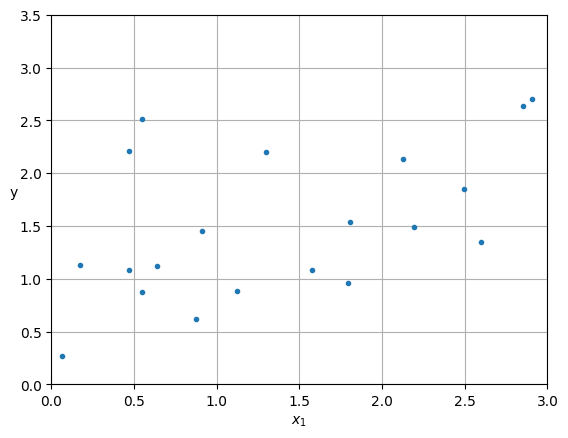

In [37]:
plt.plot(X, y, ".")
plt.xlabel("$x_1$")
plt.ylabel("y", rotation=0)
plt.axis([0, 3, 0, 3.5])
plt.grid()
plt.show()

Here we define a function that draw a plot using model-class regularization, if polynomial is True, it draws a 10th-degree polynomial, else it draws a line.

In [38]:
from sklearn.linear_model import Ridge


def plot_model(model_class, polynomial, alphas, **model_kwargs):
    plt.plot(X, y, "b.", linewidth=3)
    for alpha, style in zip(alphas, ("b:", "g--", "r-")):
        if alpha > 0:
            model = model_class(alpha, **model_kwargs)
        else:
            model = LinearRegression()
        if polynomial:
            model = make_pipeline(
                PolynomialFeatures(degree=10, include_bias=False),
                StandardScaler(),
                model,
            )
        model.fit(X, y)
        y_new_regularized = model.predict(X_new)
        plt.plot(
            X_new, y_new_regularized, style, linewidth=2.0, label=rf"$\alpha=${alpha}"
        )
    plt.grid()
    plt.xlabel("$x_1$")
    plt.legend(loc="upper left")
    plt.axis([0, 3, 0, 3.5])

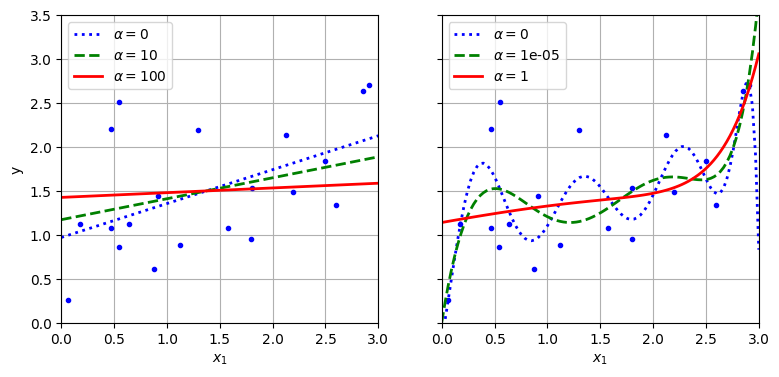

In [39]:
plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_model(Ridge, polynomial=False, alphas=(0, 10, 100), random_state=42)
plt.ylabel("y")
plt.subplot(122)
plot_model(Ridge, polynomial=True, alphas=(0, 1e-5, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

Here are two way to approach ridge regression. The first one is using a variant of closed-form equation by AndrĂ©-Louis Cholesky

In [40]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(
    alpha=0.1, solver="cholesky"
)  # solver means way to calculate the ridge, read the docstring
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[1.55325833]])

And the second one is SGD.

In [41]:
sgd_reg = SGDRegressor(
    penalty="l2", alpha=0.1 / m, tol=None, max_iter=1000, eta0=0.01, random_state=42
)
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([1.55302613])

We divide alpha by m to obtain the same result as Ridge(alpha=0.1)

## Lasso regression

Here we plot the same image as the previous image, just replace ridge with lasso and change alpha.

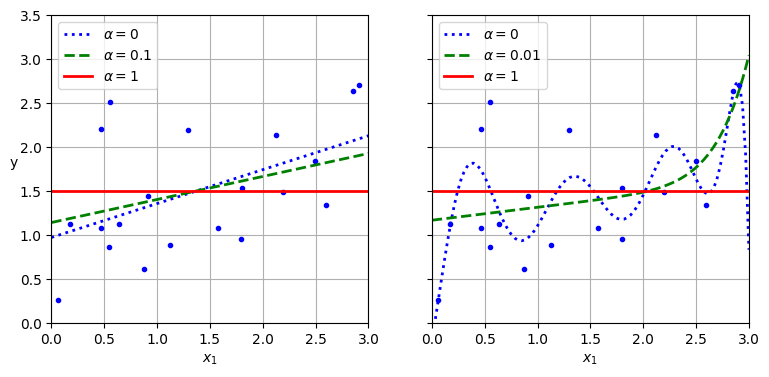

In [42]:
from sklearn.linear_model import Lasso

plt.figure(figsize=(9, 4))
plt.subplot(121)
plot_model(Lasso, polynomial=False, alphas=(0, 0.1, 1), random_state=42)
plt.ylabel("y", rotation=0)
plt.subplot(122)
plot_model(Lasso, polynomial=True, alphas=(0, 0.01, 1), random_state=42)
plt.gca().axes.yaxis.set_ticklabels([])
plt.show()

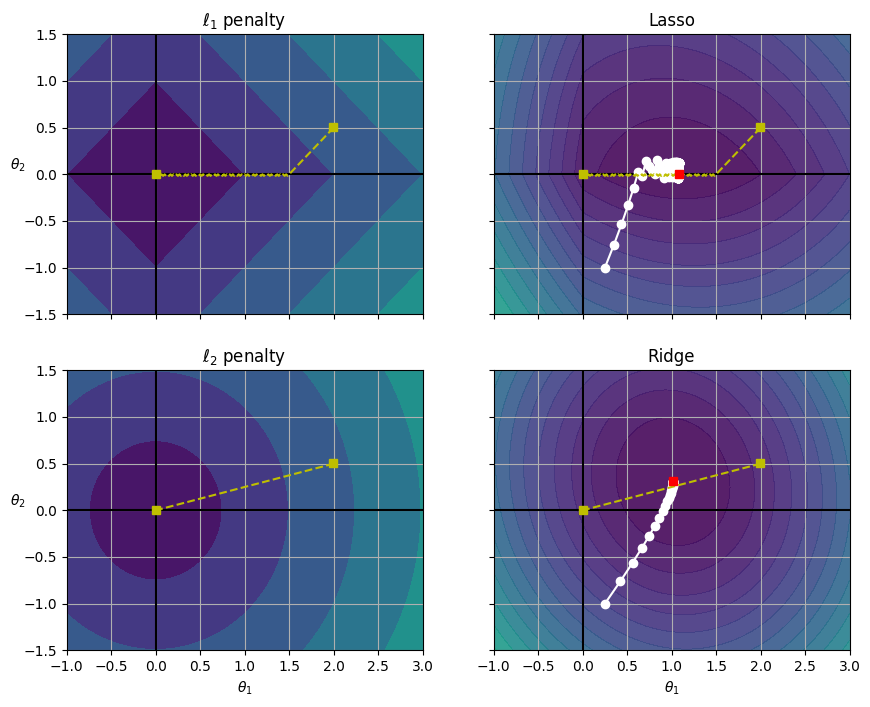

In [43]:
# extra code â€“ this BIG cell generates and saves Figure 4â€“19

t1a, t1b, t2a, t2b = -1, 3, -1.5, 1.5

t1s = np.linspace(t1a, t1b, 500)
t2s = np.linspace(t2a, t2b, 500)
t1, t2 = np.meshgrid(t1s, t2s)
T = np.c_[t1.ravel(), t2.ravel()]
Xr = np.array([[1, 1], [1, -1], [1, 0.5]])
yr = 2 * Xr[:, :1] + 0.5 * Xr[:, 1:]

J = (1 / len(Xr) * ((T @ Xr.T - yr.T) ** 2).sum(axis=1)).reshape(t1.shape)

N1 = np.linalg.norm(T, ord=1, axis=1).reshape(t1.shape)
N2 = np.linalg.norm(T, ord=2, axis=1).reshape(t1.shape)

t_min_idx = np.unravel_index(J.argmin(), J.shape)
t1_min, t2_min = t1[t_min_idx], t2[t_min_idx]

t_init = np.array([[0.25], [-1]])


def bgd_path(theta, X, y, l1, l2, core=1, eta=0.05, n_iterations=200):
    path = [theta]
    for iteration in range(n_iterations):
        gradients = (
            core * 2 / len(X) * X.T @ (X @ theta - y) + l1 * np.sign(theta) + l2 * theta
        )
        theta = theta - eta * gradients
        path.append(theta)
    return np.array(path)


fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10.1, 8))

for i, N, l1, l2, title in ((0, N1, 2.0, 0, "Lasso"), (1, N2, 0, 2.0, "Ridge")):
    JR = J + l1 * N1 + l2 * 0.5 * N2**2

    tr_min_idx = np.unravel_index(JR.argmin(), JR.shape)
    t1r_min, t2r_min = t1[tr_min_idx], t2[tr_min_idx]

    levels = np.exp(np.linspace(0, 1, 20)) - 1
    levelsJ = levels * (J.max() - J.min()) + J.min()
    levelsJR = levels * (JR.max() - JR.min()) + JR.min()
    levelsN = np.linspace(0, N.max(), 10)

    path_J = bgd_path(t_init, Xr, yr, l1=0, l2=0)
    path_JR = bgd_path(t_init, Xr, yr, l1, l2)
    path_N = bgd_path(
        theta=np.array([[2.0], [0.5]]),
        X=Xr,
        y=yr,
        l1=np.sign(l1) / 3,
        l2=np.sign(l2),
        core=0,
    )
    ax = axes[i, 0]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, N / 2.0, levels=levelsN)
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.set_title(rf"$\ell_{i + 1}$ penalty")
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")
    ax.set_ylabel(r"$\theta_2$", rotation=0)

    ax = axes[i, 1]
    ax.grid()
    ax.axhline(y=0, color="k")
    ax.axvline(x=0, color="k")
    ax.contourf(t1, t2, JR, levels=levelsJR, alpha=0.9)
    ax.plot(path_JR[:, 0], path_JR[:, 1], "w-o")
    ax.plot(path_N[:, 0], path_N[:, 1], "y--")
    ax.plot(0, 0, "ys")
    ax.plot(t1_min, t2_min, "ys")
    ax.plot(t1r_min, t2r_min, "rs")
    ax.set_title(title)
    ax.axis([t1a, t1b, t2a, t2b])
    if i == 1:
        ax.set_xlabel(r"$\theta_1$")

plt.show()

Here is how you use Lasso in scikit-learn. Equivalently, you can use SGDRegressor(penalty='l1').

In [44]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha=0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([1.53788174])

## Elastic Net

Here is how you use Elastic Net in scikit-learn. l1_ratio corresponds to the mix ratio r.

In [45]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([1.54333232])

## Early Stopping

In [46]:
from copy import deepcopy
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(m, 1)
X_train, y_train = X[: m // 2], y[: m // 2, 0]
X_valid, y_valid = X[m // 2 :], y[m // 2 :, 0]

In [47]:
preprocessing = make_pipeline(
    PolynomialFeatures(degree=90, include_bias=False), StandardScaler()
)
X_train_prep = preprocessing.fit_transform(X_train)
X_valid_prep = preprocessing.transform(X_valid)
sgd_reg = SGDRegressor(penalty=None, eta0=2e-3, random_state=42)
n_epochs = 500
best_valid_rmse = float("inf")
train_errors, valid_errors = [], []  # extra code for the figure below

In [48]:
for epoch in range(n_epochs):
    sgd_reg.partial_fit(X_train_prep, y_train)
    y_valid_predict = sgd_reg.predict(X_valid_prep)
    valid_error = mean_squared_error(y_valid_predict, y_valid, squared=False)
    if valid_error < best_valid_rmse:
        best_valid_rmse = valid_error
        best_model = deepcopy(sgd_reg)

    # extra code - we evaluate the model and save it for the figure below
    y_train_predict = sgd_reg.predict(X_train_prep)
    train_error = mean_squared_error(y_train_predict, y_train)
    train_errors.append(train_error)
    valid_errors.append(valid_error)

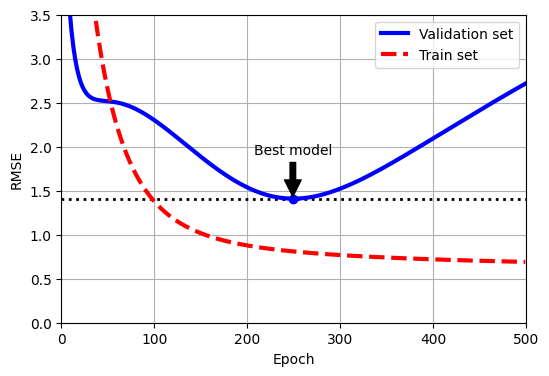

In [49]:
best_epoch = np.argmin(valid_errors)
plt.figure(figsize=(6, 4))
plt.annotate(
    "Best model",
    xy=(best_epoch, best_valid_rmse),
    xytext=(best_epoch, best_valid_rmse + 0.5),
    ha="center",
    arrowprops=dict(facecolor="black", shrink=0.05),
)
plt.plot([0, n_epochs], [best_valid_rmse, best_valid_rmse], "k:", linewidth=2)
plt.plot(valid_errors, "b-", linewidth=3, label="Validation set")
plt.plot(train_errors, "r--", linewidth=3, label="Train set")
plt.plot(best_epoch, best_valid_rmse, "bo")
plt.legend(loc="upper right")
plt.xlabel("Epoch")
plt.ylabel("RMSE")
plt.grid()
plt.axis([0, n_epochs, 0, 3.5])
plt.show()

In [50]:
test = [[1]]
test = preprocessing.transform(test)
best_model.predict(test)

array([2.64990773])

From the notes in note.md, we can implement Early Stopping using SGDRegressor as follow. In the code, it means we will stop if the validation error of the model doesn't decrease by 1e-5 after 10 iterations.

In [51]:
sgd_reg = SGDRegressor(
    penalty=None,
    eta0=2e-3,
    random_state=42,
    early_stopping=True,
    n_iter_no_change=10,
    tol=1e-5,
)
sgd_reg.fit(X_train_prep, y_train)
sgd_reg.predict(test)

array([2.66927138])

# Logistic Regression

## Estimating Probabilities

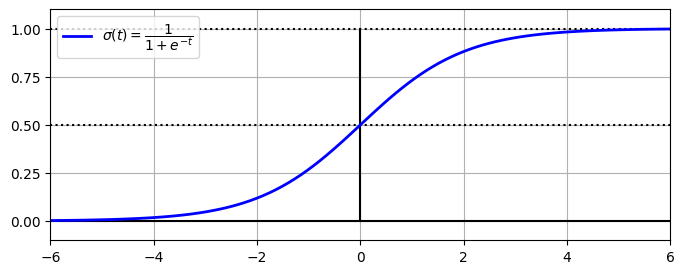

In [52]:
lim = 6
t = np.linspace(-lim, lim, 100)
sig = 1 / (1 + np.exp(-t))

plt.figure(figsize=(8, 3))
plt.plot([-lim, lim], [0, 0], "k-")
plt.plot([-lim, lim], [0.5, 0.5], "k:")
plt.plot([-lim, lim], [1, 1], "k:")
plt.plot([0, 0], [0, 1], "k-")
plt.axis([-lim, lim, -0.1, 1.1])
plt.plot(t, sig, "b-", linewidth=2, label=r"$\sigma(t) = \dfrac{1}{1 + e^{-t}}$")
plt.legend(loc="upper left")
plt.gca().set_yticks([0, 0.25, 0.5, 0.75, 1.0])
plt.grid()
plt.show()

## Decision Boundaries

In [53]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
list(iris)

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename',
 'data_module']

In [54]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [55]:
iris.data.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


In [56]:
iris.target.head(3)

0    0
1    0
2    0
Name: target, dtype: int32

In [57]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

X = iris.data[["petal width (cm)"]].values
y = iris.target_names[iris.target] == "virginica"
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [59]:
log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(random_state=42)

We need to reshape to get a column vector, because predict_proba expects a single list of vector, while np.linsapce return a vector.

In [63]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
decision_boundary = X_new[y_proba[:, 1] >= 0.5][0, 0]

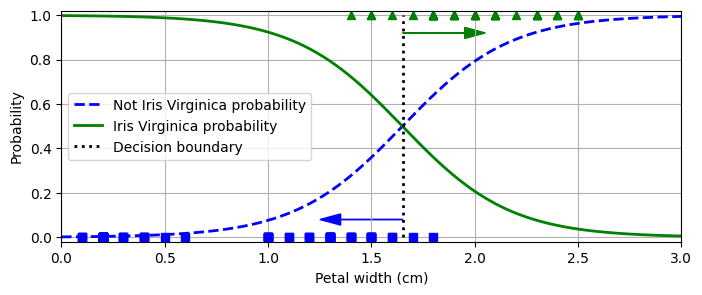

In [85]:
plt.figure(figsize=(8, 3))
plt.plot(
    X_new, y_proba[:, 1], "b--", linewidth=2, label="Not Iris Virginica probability"
)
plt.plot(X_new, y_proba[:, 0], "g-", linewidth=2, label="Iris Virginica probability")
plt.plot(
    [decision_boundary, decision_boundary],
    [0, 1],
    "k:",
    linewidth=2,
    label="Decision boundary",
)

plt.arrow(
    x=decision_boundary,
    y=0.08,
    dx=-0.3,
    dy=0,
    head_width=0.05,
    head_length=0.1,
    fc="b",
    ec="b",
)
plt.arrow(
    x=decision_boundary,
    y=0.92,
    dx=0.3,
    dy=0,
    head_width=0.05,
    head_length=0.1,
    fc="g",
    ec="g",
)
plt.plot(X_train[y_train == 0], y_train[y_train == 0], "bs")
plt.plot(X_train[y_train == 1], y_train[y_train == 1], "g^")

plt.xlabel("Petal width (cm)")
plt.ylabel("Probability")
plt.axis([0, 3, -0.02, 1.02])
plt.legend(loc="center left")
plt.grid()
plt.show()

In [86]:
decision_boundary

1.6516516516516517

In [88]:
log_reg.predict([[1.7], [1.6]])

array([ True, False])

In [92]:
X = iris.data[["petal length (cm)", "petal width (cm)"]].values
y = iris.target_names[iris.target] == "virginica"
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

log_reg = LogisticRegression(C=2, random_state=42)
log_reg.fit(X_train, y_train)

LogisticRegression(C=2, random_state=42)

In [106]:
x0, x1 = np.meshgrid(
    np.linspace(2.9, 7, 500).reshape(-1, 1), np.linspace(0.8, 2.7, 200).reshape(-1, 1)
)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_proba = log_reg.predict_proba(X_new)
zz = y_proba[:, 1].reshape(x0.shape)

In [101]:
left_right = np.array([2.9, 7])
boundary = -(
    (log_reg.coef_[0, 0] * left_right + log_reg.intercept_[0]) / log_reg.coef_[0, 1]
)

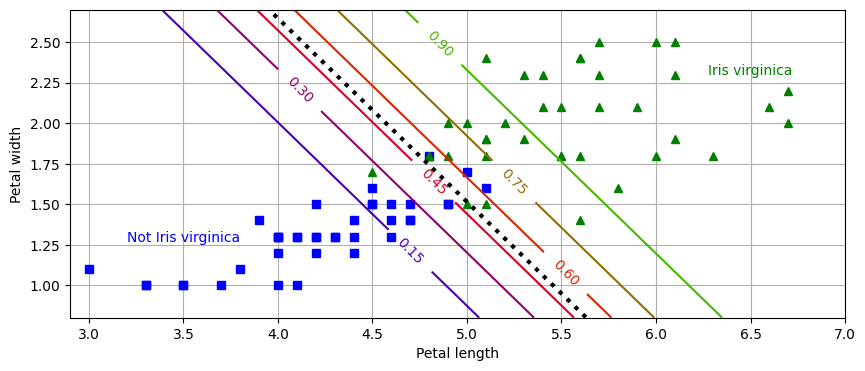

In [115]:
plt.figure(figsize=(10, 4))
plt.plot(X_train[y_train == 0, 0], X_train[y_train == 0, 1], "bs")
plt.plot(X_train[y_train == 1, 0], X_train[y_train == 1, 1], "g^")
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.clabel(contour, inline=1)
plt.plot(left_right, boundary, "k:", linewidth=3)
plt.text(3.5, 1.27, "Not Iris virginica", color="b", ha="center")
plt.text(6.5, 2.3, "Iris virginica", color="g", ha="center")

plt.xlabel("Petal length")
plt.ylabel("Petal width")
plt.axis([2.9, 7, 0.8, 2.7])
plt.grid()
plt.show()